# H&M Personalized Fashion Recommendations

## Purpose

To develop product recommendations based on data from previous transactions and product and customer metadata. Using ML techniques, we will build a model to predict what articles each customer will purchase in the following 7-day period.  Customers who didn't make a purchase will be excluded from scoring.  

## Datasets
- articles.csv 
    - appearance
    - product family
    - name
- customers.csv
    - club status 
    - age
    - postal code
- transactions_train.csv
    - data to train the completed model on

In [2]:
# set up paths and create datasets
import os
import pandas as pd
from dask import dataframe as dframe # the training dataset is hugenormous so we'll let dask handle it

# create paths based on current working directory
data_folder = os.path.join(os.getcwd(), 'data')
hm_datasets = os.path.join(data_folder, 'h-and-m-personalized-fashion-recommendations')
print(os.listdir(hm_datasets))

# convert csv files to dataframes
customers = pd.read_csv(os.path.join(hm_datasets, 'customers.csv'))
articles = pd.read_csv(os.path.join(hm_datasets, 'articles.csv'))
submission = pd.read_csv(os.path.join(hm_datasets, 'sample_submission.csv'))
txs = dframe.read_csv(os.path.join(hm_datasets,'transactions_train.csv'))

['customers.csv', 'sample_submission.csv', 'transactions_train.csv', 'articles.csv']


In [3]:
submission.iloc[0][1]

'0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001'

In [51]:
customers.head()
print(customers.nunique())

customer_id               1371980
FN                              1
Active                          1
club_member_status              3
fashion_news_frequency          4
age                            84
postal_code                352899
dtype: int64


In [48]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [6]:
txs.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


# Exploring the Data

## Building a dataset

We'll start by grouping customers based on certain characteristics.  Some of these could include:
- total spend
- number of items purchased 
- types of items purchased
- demographics (postal code, age, fn status, club membership) 

From there we can start taking <a href=https://www.investopedia.com/ask/answers/032615/what-are-some-examples-stratified-random-sampling.aspstratified> stratisfied samples </a> or begin <a href=https://en.wikipedia.org/wiki/Cluster_analysis> analyzing clusters </a> where patterns of purchases may emerge.  Since we need to build the model on a subset of the data, we need to ensure that we can capture a representative sample while avoiding overfitting.

In [7]:
# how many unique customers are in the training dataset? 
len(set(txs['customer_id']))

1362281

In [8]:
# is it equivalent to the number of customers in the customers dataset?
len(customers)

1371980

In [9]:
customers['age'].describe().round(2)

count    1356119.00
mean          36.39
std           14.31
min           16.00
25%           24.00
50%           32.00
75%           49.00
max           99.00
Name: age, dtype: float64

In [10]:
# cleaning customers
c_customers = customers.copy()
c_customers[['FN','Active']] = c_customers[['FN','Active']].fillna(0)

<AxesSubplot:xlabel='age', ylabel='Count'>

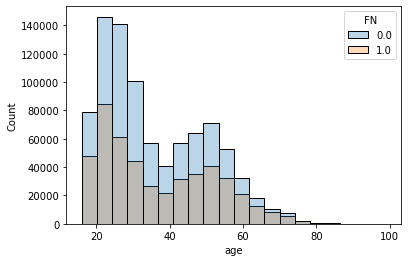

In [11]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
c_customers = customers.copy()
c_customers['FN'] = customers['FN'].fillna(0)
sns.histplot(data=c_customers,x='age',hue='FN', alpha=.3, bins=20)

The customer age follows a bimodal distribution, concentrating around 25 years old and 55 years old, it seems that older customers are more likely to be FN subscribers.

In [12]:
# take a 10% customer sample from transactions
r_state = 10

sample_10 = customers.sample(frac=.1,random_state = r_state) # take 10% random sample of customer ids
dask_10 = txs[txs['customer_id'].isin(sample_10['customer_id'])].compute() # filter the dataset to just sampled customers

In [49]:
print(articles.columns)

name_filter = [word for word in articles.columns if 'name' in word] # list comprehension (the cool way)

# test_names = [] # regular way (not as cool)
# for word in articles.columns:
#     if 'name' in word:
#         test_names.append(word)
# test_nanes

# find the count of unique values for each column in articles dataframe

article_names = articles[name_filter].copy()

for col in article_names:
    print(col, article_names[col].nunique())
    
articles[['product_code','prod_name']].nunique()

colors = [word for word in name_filter if 'colour' in word]

articles[colors].head()

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')
prod_name 45875
product_type_name 131
product_group_name 19
graphical_appearance_name 30
colour_group_name 50
perceived_colour_value_name 8
perceived_colour_master_name 20
department_name 250
index_name 10
index_group_name 5
section_name 56
garment_group_name 21


,colour_group_name,perceived_colour_value_name,perceived_colour_master_name
0,Black,Dark,Black
1,White,Light,White
2,Off White,Dusty Light,White
3,Black,Dark,Black
4,White,Light,White


It looks like product code and name might be a messy column to use, for example there is a value `Strap Top` as well as `Strap Top (1)` which share the same product code, however there are about 1500 more unique product codes vs names.  It would therefore add more noise to our model than useful information to try and wrangle that, when the combination of other columns as well as unique article ID would be sufficient. We can now drop product name from our filter. 

In [17]:
dask_10.groupby(['customer_id']).count()

,t_dat,article_id,price,sales_channel_id
customer_id,,,,
0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff,3,3,3,3
0000d6c053fc8f9389d4565051f12402d5774aa4a9d2e5c2d5cd5f5f3c9a4488,7,7,7,7
0000ffa57a8098a6cd99c0f0782b3e674f47d68db69dc173c7e67e0f68170c4c,3,3,3,3
0001177027259b455f979d85a278e4b280205d4de5cce4bb83ccbb8d5dbb4b92,37,37,37,37
00015c1a121e08bbd2552c15fbbb6e6b19d3bf8f7b6a3d60c6d7be26f06264d6,41,41,41,41
...,...,...,...,...
fffd01e2dc2270a6635e9bfb6c9a647832f3167ce0275be46fe0293b50d664d6,26,26,26,26
fffd70b14382482cf3d10def86df367b2b6e0af711dede538a6a036dcc04da0b,41,41,41,41
fffe61b99c2d0418ed22190a8490b142247e8897c67941ce25f78a99656e9f63,1,1,1,1


In [55]:
# classifying a single customers's purchases
cust_1 = dask_10[dask_10['customer_id'] == 'ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264'].copy()

training_cols = ['article_id','price','product_code','product_type_no','graphical_appearance_no',
                'colour_group_code','perceived_colour_value_id','perceived_colour_master_id','department_no',
                'index_code','index_group_no','section_no','garment_group_no']

combined = cust_1.merge(articles,on="article_id")
combined.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id',
       'product_code', 'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')